# Analyzing Biodiversity and Conservation Status in National Parks.

## Introduction:

This is my second python project shared on Github. I will explore and perform data analysis on 2 datasets, sourced from the National Parks Service.

### Goals:
I will be looking to answer more questions as I begin exploring the data, but these questions will guide my intial exploration:

- What is the distribution of `conservation_status` for animals?  
- Are certain types of species more likely to be endangered?  
- Are the differences between species and their conservation status significant?  
- Which species were spotted the most at each park?

### Raw Data Files:

**species_info.csv** - contains data about different species and their conservation status.  
`category` - class of animal  
`scientific_name` - the scientific name of each species  
`common_name` - the common names of each species  
`conservation_status` - each species' current conservation status  

**observations.csv** - holds recorded sightings of different species at several national parks for the past 7 days.  
`scientific_name` - the scientific name of each species  
`park_name` - park where species were found  
`observations` - the number of times each species was observed at the park

## Load CSV Files: inspect first 10 rows.

During my review of the column names, I have decided not to name the DataFrame 'Observations' due to the identical column name. To avoid confusion, I will instead use 'tracking' as a synonym instead of observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
species_df = pd.read_csv("~/Desktop/GitHub/BioDiversity-Project/Analysis/species_info.csv")
tracking_df = pd.read_csv("~/Desktop/GitHub/BioDiversity-Project/Analysis/observations.csv")

In [3]:
species_df.head()

category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN

In [4]:
species_df.dtypes

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object

In [5]:
tracking_df.head()

scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85

In [6]:
tracking_df.dtypes

scientific_name    object
park_name          object
observations        int64
dtype: object

## Digging into the missing data.

I only see `NaN` values in  **species_df** for the column `conservation_status`- this will be something to look into a bit deeper as I begin to clean the data.  
*I also see that both df's contain the column `scientific_name`. This will be useful to act as a primary key, linking both tables by a shared relation if I choose to join both df's.*

**For now, though, I want to continue exploring the data while looking more into each column to see if any others contain NaN, or other possible issues that could be addressed with data cleaning.**

In [7]:
species_df_shape = species_df.columns, species_df.shape

species_df_shape

(Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object'),
 (5824, 4))

In [8]:
tracking_df_shape = tracking_df.columns, tracking_df.shape

tracking_df_shape 

(Index(['scientific_name', 'park_name', 'observations'], dtype='object'),
 (23296, 3))

In [9]:
species_null = species_df.isnull().sum().sort_values(ascending=False)

species_null

conservation_status    5633
category                  0
scientific_name           0
common_names              0
dtype: int64

In [10]:
total_rows, total_col = species_df.shape
null_rows = species_null[0]
null_per = (null_rows/total_rows) *100

print(f"{null_per.round(3)}% of the rows in the conservation_status column are null.")

96.72% of the rows in the conservation_status column are null.


In [11]:
tracking_null = tracking_df.isnull().sum().sort_values(ascending=False)

tracking_null

scientific_name    0
park_name          0
observations       0
dtype: int64

**Diving deeper I see a majority of the rows in the `conservation_status` column have null values. I want to know if the missing values are: systematic, MAR, MCAR, or MNAR? Without much domain knowledge, I will look closer at the non-null values.**

In [12]:
conservation_types = species_df['conservation_status'].unique()

print("conservation_types:", conservation_types)
species_df['conservation_status'].value_counts()

conservation_types: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: conservation_status, dtype: int64

**`Conservation Status`** is an ordinal categorical variable with 4 categories: 
- Species of Concern, 
- Endangered, 
- Threatened, 
- In recovery. 
 
**It seems less surprising now, why there is a significant portion of null values (96.72%) - it is common for a species to not fit 1 of the 4 categories, which suggests that `NaN` values represent *no* conservation status,i.e. the species is not at risk.**

This insight allows me to make an important assumption: that `NaN` values are systematically missing due to the dataset only recording conservation status for species known to be at risk. However, it is crucial to remember that this is an assumption, and I should seek to verify it throughout my analysis while ensuring the reader of the analysis is made aware, of this and all assumptions.

To perform a more comprehensive analysis, I will modify the null values to represent a 'Healthy' conservation status, indicating that the species is not considered at risk. This relabeling allows us to include these records in our analysis without the need to fill the null values or delete the rows.

In [13]:
species_df['conservation_status'] = species_df['conservation_status'].fillna('Healthy').astype('category')
con_status = species_df['conservation_status'].astype('category')

labels = con_status.unique()
con_status_counts = con_status.value_counts()

con_status_counts

Healthy               5633
Species of Concern     161
Endangered              16
Threatened              10
In Recovery              4
Name: conservation_status, dtype: int64

In [14]:
prop = (con_status_counts/total_rows)*100

prop

Healthy               96.720467
Species of Concern     2.764423
Endangered             0.274725
Threatened             0.171703
In Recovery            0.068681
Name: conservation_status, dtype: float64

## Some insight into Q1. What is the distribution of `conservation_status` for animals?  

Before fully diving into Q1, I do want to quickly investigate the question with the current understanding so far established through the analysis up to this point. **Since I am not familiar with this dataset/domain of knowledge, I find it helpful to take extra time learning about the basic features, and how they relate.**

For example, it is more obvious looking at the proportions above to understand the distribution of species this dataset contains. It prepares me for further EDA, where I'd be interested in learning more about the distribution of `conservation_status` by national park - maybe some parks are home to more at-risk species than other parks!

### A visual of the `conservation_status` proportions:

In [15]:
legend_labels = [f'{label} - {prop:.1f}%' for label, prop in zip(labels, prop)]

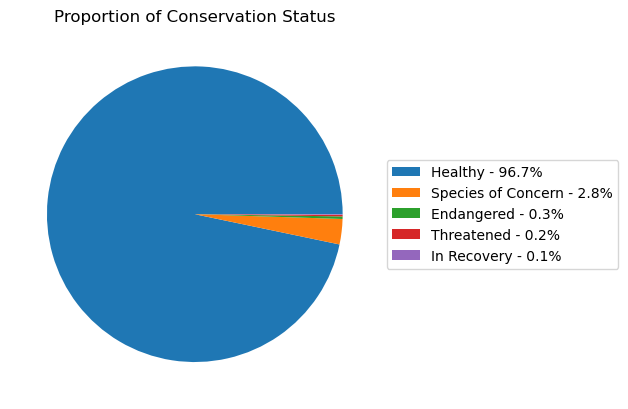

<Figure size 640x480 with 0 Axes>

In [27]:
plt.pie(con_status_counts)
plt.title('Proportion of Conservation Status')
plt.legend(legend_labels,bbox_to_anchor=(1, 0.5), loc='center left')

plt.show()
plt.clf()

It is hard to see any color except for **blue** and **orange**, indicating the other values are much less frequent.

With this additional understanding, I can think of 2 more questions I am interested in analyzing during EDA -- what is the proportion of `convservation_status` by:
- `national_park`?; to investigate if some parks are more difficult for a species to survive in.
- `category`?; to investigate if some categories of species have more difficulty surviving than others.

### Before performing in-depth EDA, I want to backup and finish the data cleaning.. I need to identify all duplicate rows.

In [17]:
s_dups = species_df.duplicated()
t_dups = tracking_df.duplicated()

s_dups.sum(), t_dups.sum()

(0, 15)

In [18]:
duplicates = tracking_df[tracking_df.duplicated(keep=False)]

duplicates.sort_values(by=['scientific_name'])

scientific_name                            park_name  \
513             Arctium minus               Yosemite National Park   
10674           Arctium minus               Yosemite National Park   
4527   Botrychium virginianum            Yellowstone National Park   
20294  Botrychium virginianum            Yellowstone National Park   
19392       Cichorium intybus            Yellowstone National Park   
14142       Cichorium intybus            Yellowstone National Park   
7263   Echinochloa crus-galli  Great Smoky Mountains National Park   
1454   Echinochloa crus-galli  Great Smoky Mountains National Park   
1020     Eleocharis palustris  Great Smoky Mountains National Park   
12381    Eleocharis palustris  Great Smoky Mountains National Park   
1032      Hesperis matronalis                  Bryce National Park   
13372     Hesperis matronalis                  Bryce National Park   
4178     Monotropa hypopithys  Great Smoky Mountains National Park   
20820    Monotropa hypopithys  Great Smoky Mountains National Park   
10038          Plantago major  Great Smoky Mountains National Park   
365            Plantago major  Great Smoky Mountains National Park   
18141           Poa compressa  Great Smoky Mountains National Park   
13097           Poa compressa  Great Smoky Mountains National Park   
17378    Potentilla norvegica               Yosemite National Park   
10809    Potentilla norvegica               Yosemite National Park   
7219        Prunella vulgaris  Great Smoky Mountains National Park   
16741       Prunella vulgaris  Great Smoky Mountains National Park   
19575            Salix exigua               Yosemite National Park   
22698            Salix exigua               Yosemite National Park   
17577      Spilogale putorius            Yellowstone National Park   
627        Spilogale putorius            Yellowstone National Park   
8710    Streptopelia decaocto            Yellowstone National Park   
1635    Streptopelia decaocto            Yellowstone National Park   
21151     Trifolium campestre            Yellowstone National Park   
18435     Trifolium campestre            Yellowstone National Park   

       observations  
513             162  
10674           162  
4527            232  
20294           232  
19392           266  
14142           266  
7263             62  
1454             62  
1020             62  
12381            62  
1032            124  
13372           124  
4178             73  
20820            73  
10038            90  
365              90  
18141            80  
13097            80  
17378           148  
10809           148  
7219             75  
16741            75  
19575           186  
22698           186  
17577           256  
627             256  
8710            255  
1635            255  
21151           239  
18435           239

The rows above are all duplicates. There seems to be no reason for including both records so i will now drop all duplicates, and check to ensure there are no further duplicates.

In [19]:
tracking_df = tracking_df.drop_duplicates()

tracking_df.duplicated().sum()

0

### At this point all null values have been handled, and all duplicates removed. The data is much cleaner!

Now, it would be beneficial to merge the two dataframes, enabling more comprehensive analysis, such as examining the relationship between `conservation_status` and `park_name`. *This could reveal if certain parks have a lower proportion of 'Healthy' species, suggesting that the park might be a 'high-risk' location for specific species.*

In [28]:
data = pd.merge(species_df, tracking_df, on='scientific_name')

In [21]:
check = data[data['scientific_name'] == 'Bos bison']
check

category scientific_name           common_names conservation_status  \
4   Mammal       Bos bison  American Bison, Bison             Healthy   
5   Mammal       Bos bison  American Bison, Bison             Healthy   
6   Mammal       Bos bison  American Bison, Bison             Healthy   
7   Mammal       Bos bison  American Bison, Bison             Healthy   

                             park_name  observations  
4               Yosemite National Park           128  
5            Yellowstone National Park           269  
6                  Bryce National Park            68  
7  Great Smoky Mountains National Park            77

### We can now see how helpful it is to have the combined dataframes into 1 dataframe. With this quick example, 'check' is showing us this particular species is 'Healthy' in all parks!

Perhaps, some parks have higher concentrations of non-healthy species? And if so, do some category types (e.g. mammal, fish,etc.) have a high liklihood of becoming non-healthy?

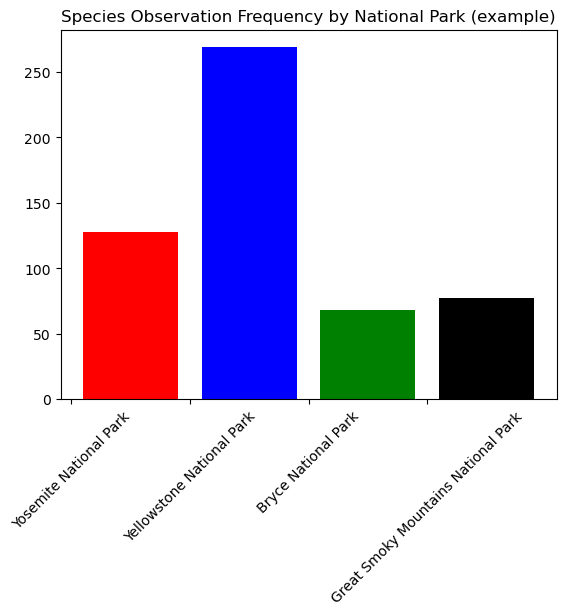

<Figure size 640x480 with 0 Axes>

In [22]:
plt.bar(x=check.park_name,height=check.observations,color=['red','blue','green','black'])
plt.xticks(np.arange(4)-0.5,check.park_name,rotation=45)
plt.title("Species Observation Frequency by National Park (example)")
plt.show()
plt.clf()

The bar plot clearly highlights the national park in which the American Bison is most commonly sighted. 
**This sample of data visually helps me understand the dataset better, so when it comes to conducting a comprehensive analysis, I am more prepared.**

## Summary Statistics
Before performing **Exploratory Data Analysis**, I want to know the summary statistics. Now that my data is clean, and both csv files are merged into 1 Dataframe (joined by their shared column, `scientific_name`), I think it is a great time to see the summary statistics:

In [26]:
sum_stats = data.describe(include='all')
sum_stats

category       scientific_name        common_names  \
count            25601                 25601               25601   
unique               7                  5541                5504   
top     Vascular Plant  Hypochaeris radicata  Brachythecium Moss   
freq             19534                    36                  28   
mean               NaN                   NaN                 NaN   
std                NaN                   NaN                 NaN   
min                NaN                   NaN                 NaN   
25%                NaN                   NaN                 NaN   
50%                NaN                   NaN                 NaN   
75%                NaN                   NaN                 NaN   
max                NaN                   NaN                 NaN   

       conservation_status            park_name  observations  
count                25601                25601  25601.000000  
unique                   5                    4           NaN  
top                Healthy  Bryce National Park           NaN  
freq                 24721                 6406           NaN  
mean                   NaN                  NaN    142.196477  
std                    NaN                  NaN     69.901035  
min                    NaN                  NaN      9.000000  
25%                    NaN                  NaN     86.000000  
50%                    NaN                  NaN    123.000000  
75%                    NaN                  NaN    195.000000  
max                    NaN                  NaN    321.000000

## Exploring Distribution by National Park for All Species
To begin my EDA I want to compare the total distribution of species across all national parks in this data set. This will tell me if some parks are home to more species in general, and also individually.

In [24]:
import matplotlib.cm as cm
x = np.arange(len(data))

colors = cm.tab10(x)

In [25]:
yosemite = data[data.park_name == 'Yosemite National Park']
yosemite

category                scientific_name  \
3              Mammal  Clethrionomys gapperi gapperi   
4              Mammal                      Bos bison   
9              Mammal                     Bos taurus   
12             Mammal                     Ovis aries   
19             Mammal                 Cervus elaphus   
...               ...                            ...   
25584  Vascular Plant               Solanum parishii   
25588  Vascular Plant                  Solanum xanti   
25589  Vascular Plant         Parthenocissus vitacea   
25595  Vascular Plant              Vitis californica   
25600  Vascular Plant            Tribulus terrestris   

                                            common_names conservation_status  \
3                               Gapper's Red-Backed Vole             Healthy   
4                                  American Bison, Bison             Healthy   
9      Aurochs, Aurochs, Domestic Cattle (Feral), Dom...             Healthy   
12     Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)             Healthy   
19                                         Wapiti Or Elk             Healthy   
...                                                  ...                 ...   
25584                                Parish's Nightshade             Healthy   
25588            Chaparral Nightshade, Purple Nightshade             Healthy   
25589        Thicket Creeper, Virginia Creeper, Woodbine             Healthy   
25595            California Grape, California Wild Grape             Healthy   
25600  Bullhead, Caltrop, Goathead, Mexican Sandbur, ...             Healthy   

                    park_name  observations  
3      Yosemite National Park           117  
4      Yosemite National Park           128  
9      Yosemite National Park           124  
12     Yosemite National Park           126  
19     Yosemite National Park           203  
...                       ...           ...  
25584  Yosemite National Park           162  
25588  Yosemite National Park           150  
25589  Yosemite National Park           156  
25595  Yosemite National Park           164  
25600  Yosemite National Park           156  

[6402 rows x 6 columns]